# TP2 - Estimation de densité
----

## Chargement et visualisation des données
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

Liste des types de POI furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar


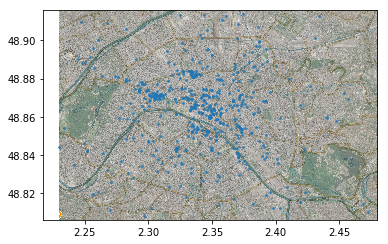

In [2]:
plt.ion()
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')

## coordonnees GPS de la carte
xmin,xmax = 2.23,2.48   ## coord_x min et max
ymin,ymax = 48.806,48.916 ## coord_y min et max

def show_map():
    plt.imshow(parismap,extent=[xmin,xmax,ymin,ymax],aspect=1.5)
    ## extent pour controler l'echelle du plan
    
poidata = pickle.load(open("data/poi-paris.pkl","rb"))
# pickle.dump(poidata, open("data/poi-paris2.pkl", "wb"), protocol=2)
## liste des types de point of interest (poi)
print("Liste des types de POI" , ", ".join(poidata.keys()))

## Choix d'un poi
typepoi = "night_club"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]),2))
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0][::-1]

## Affichage brut des poi
show_map()
## alpha permet de regler la transparence, s la taille
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)

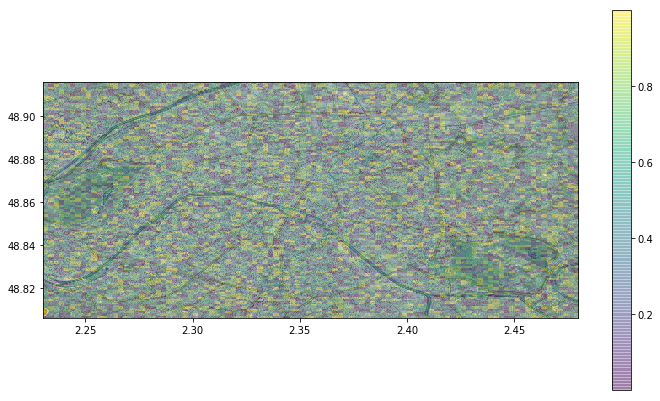

In [3]:
# discretisation pour l'affichage des modeles d'estimation de densite
steps = 100
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[xx.ravel(),yy.ravel()]

# A remplacer par res = monModele.predict(grid).reshape(steps,steps)
res = np.random.random((steps,steps))
plt.figure(figsize = (12,7))
show_map()
plt.imshow(res,extent=[xmin,xmax,ymin,ymax],interpolation='none',\
               alpha=0.3,origin = "lower")
plt.colorbar()
#plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.3)

## Expérimentations
---

### Affichage

In [4]:
def affichage(xmin, xmax, ymin, ymax, steps, modele, points=False, title=""):
    # discretisation pour l'affichage des modeles d'estimation de densite
    xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
    grid = np.c_[xx.ravel(),yy.ravel()]

    res = modele.predict(grid).reshape(steps,steps)
    plt.figure(figsize = (12,7))
    show_map()
    plt.title(title)
    plt.imshow(res,extent=[xmin,xmax,ymin,ymax],interpolation='none',\
                   alpha=0.3,origin = "lower")
    #plt.colorbar()
    if points:
        plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.1)
    return res

### Méthode des histogrammes
----

In [5]:
class HistogramMethod:
    """Classe modélisant la méthode des histogrammes
        2ème version
    """
        
    def __init__(self, xmin, xmax, ymin, ymax, steps=50, resolution=5e-8):
        self.xmin, self.ymin = xmin, ymin
        self.steps = steps
        # On rajoute une "demi-resolution"
        # pour pouvoir ajouter le dernier point
        self.dx = (xmax) - xmin
        self.dy = (ymax) - ymin
        self.resolution = resolution
        self.base = np.zeros((self.steps, self.steps))
        
    def fit(self, geo_mat):
        self.nb_points = len(geo_mat)
        for point in geo_mat:
            indx, indy = self.normalise(point)
            self.base[indx][indy] += 1
        
    def predict(self, grid):
        res = np.zeros(len(grid))   
        for i,point in enumerate(grid):
            indx, indy = self.normalise(point)
            res[i] = self.base[indx][indy]
        return res / self.nb_points
    
    def normalise(self, point):
        """ retourne les indices associés au point dans la base """
        
        # intervalle : ]a;b] sauf pour le min
        return int((point[0]-self.xmin)/self.dx*(self.steps) - self.resolution), \
                    int((point[1]-self.ymin)/self.dy*(self.steps) - self.resolution)
        

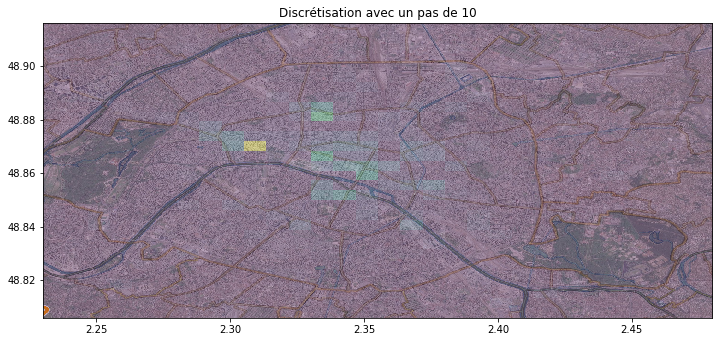

In [6]:
steps = 30
h = HistogramMethod(xmin, xmax, ymin, ymax, steps)
h.fit(geo_mat)

res = affichage(xmin, xmax, ymin, ymax, steps, h, title="Discrétisation avec un pas de 10")

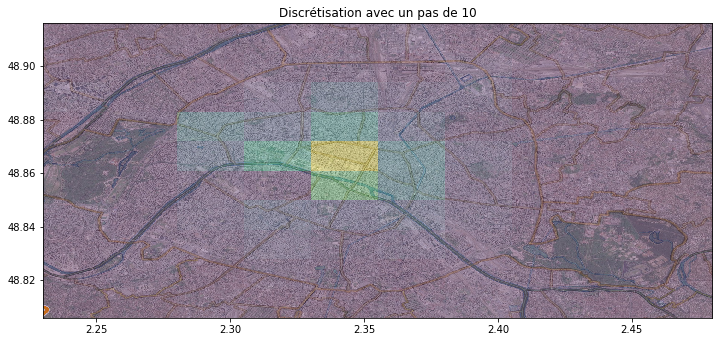

In [7]:
steps = 10
h = HistogramMethod(xmin, xmax, ymin, ymax, steps)
h.fit(geo_mat)

res = affichage(xmin, xmax, ymin, ymax, steps, h, title="Discrétisation avec un pas de 10")

In [8]:
sum(sum(res))

1.0

### Estimation non paramétrique par noyaux
----

#### Définition des noyaux

In [9]:
######### Fenetre de Parzen #########
def isOnParzenWindow(x):
    """ np.array -> float
        retourne 1 si x appartient à la fenêtre sinon 0
    """
    # Si x et y sont inférieurs à 0.5, on obtiendra un tableau contenant 2 valeurs True
    return 1 if np.sum(np.abs(x) <= 0.5) == 2 else 0

######### Noyau gaussien #########
def gaussianPhi(x):
    """ np.array -> float """
    return np.prod( 1/(np.sqrt(2*np.pi))*np.exp(-0.5*(x**2)), axis=len(x.shape)-1)

######### Noyau Laplace #########
def laplacePhi(x):
    """ np.array -> float """
    return np.prod( 0.5*np.exp(-np.abs(x)), axis=len(x.shape)-1)


In [10]:
class KernelMethod:
    """Classe modélisant une méthode à noyaux """
        
    def __init__(self, geo_mat, windowfunc=isOnParzenWindow, hn=0.01):
        self.geo_mat = geo_mat
        self.window = windowfunc
        self.hn = hn
        
        # Une méthode fit n'est pas utile
    
    def predict(self, grid):
        res = np.zeros(len(grid))
        # Hypothèse : Nos données sont de dimensions 2
        # Vn = self.hn ** 2 # densité non uniformément répartie...
        fun = np.vectorize(self.window)
        for i, xy in enumerate(grid):
            res[i] = np.sum(self.window((xy - point)/self.hn) for point in geo_mat)
        return res

#### Fenêtre de Parzen

/home/opt/anacoda/anacoda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


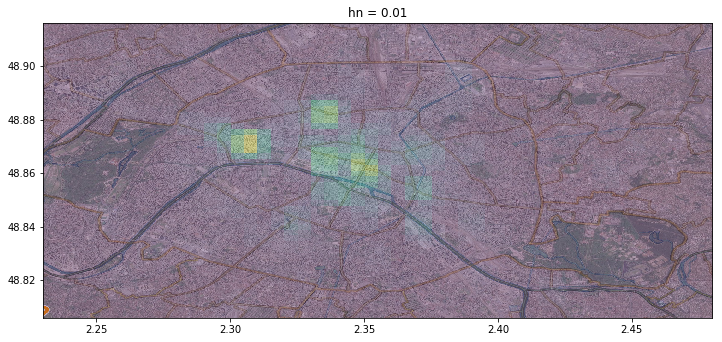

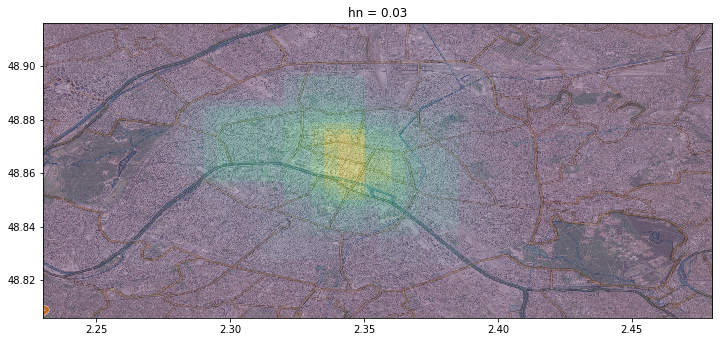

In [11]:
steps = 50
res = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, hn=0.01), title="hn = 0.01")
res2 = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, hn=0.03), title="hn = 0.03")

#### Noyau gaussien

In [ ]:
steps = 50
res = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, gaussianPhi, hn=0.005), title="hn = 0.005")
res2 = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, gaussianPhi, hn=0.02), title="hn = 0.02")

/home/opt/anacoda/anacoda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


#### Noyau Laplace

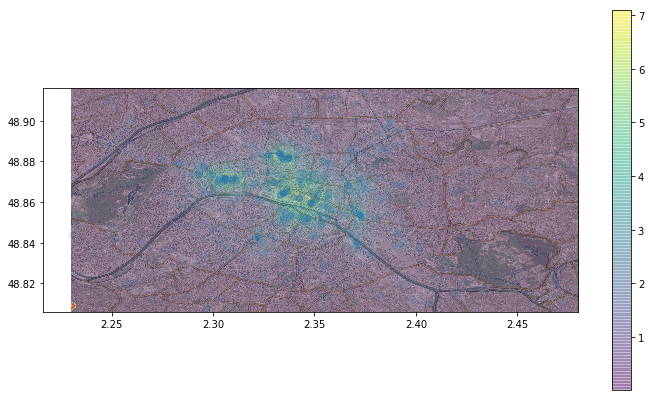

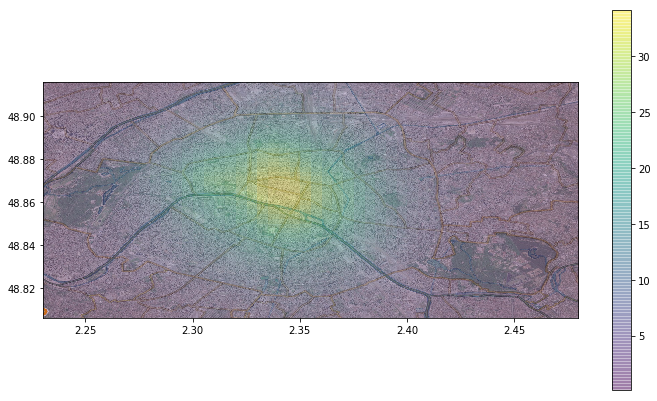

In [148]:
steps = 50
res = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, laplacePhi, hn=0.005), True)
res2 = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, laplacePhi, hn=0.02))

#### [Q] - Que se passe-t-il pour une faible/forte disrétisation pour la méthode des histogrammes ?

Une faible discrétisation provoque une faible précision et ne permet donc pas de bien visualiser les différentes variations. Au contraire, une forte discrétisation induit une forte sensibilité avec notamment la présence de valeurs extrêmes et par conséquent, de fortes discontinuités.

#### [Q] - Quel est le rôle des paramètres des méthodes à noyaux ?

Le but des méthodes à noyaux est de prendre en compte les points voisins du point étudié afin de résoudre le problème de la discrétisation. Le rôle des paramètres est de déterminer l'espace de voisinage (l'espace qui détermine les voisins à prendre en compte).

#### [Q] - Comment choisir de manière automatique les meilleurs paramètres ?

(Hypothèse) Plus le nombre de données augmente, plus un lissage avec un hn grand pourrait être nécessaire. Lorsque le nombre de données tend vers l'infini, hn n'a quasiment plus d'impact sur l'estimation.

A revoir

#### [Q] - La question reliée : comment estimer la qualité de votre modèle ? 

A revoir et répondre

### Test avec différents POI
----

In [50]:
## Choix d'un poi
typepoi = "restaurant"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]),2))
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0][::-1]

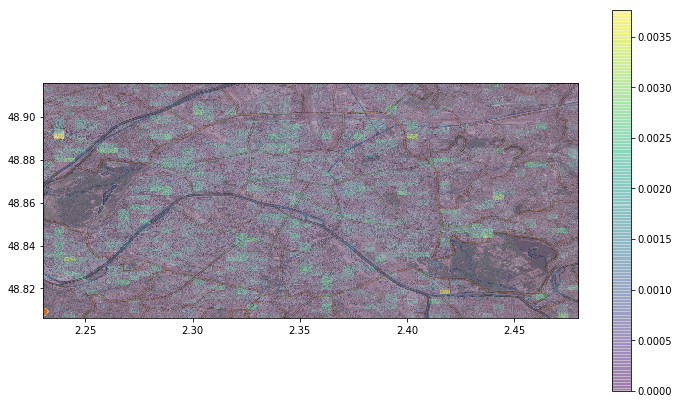

In [151]:
steps = 50
h = HistogramMethod(xmin, xmax, ymin, ymax, steps)
h.fit(geo_mat)
res = affichage(xmin, xmax, ymin, ymax, steps, h)

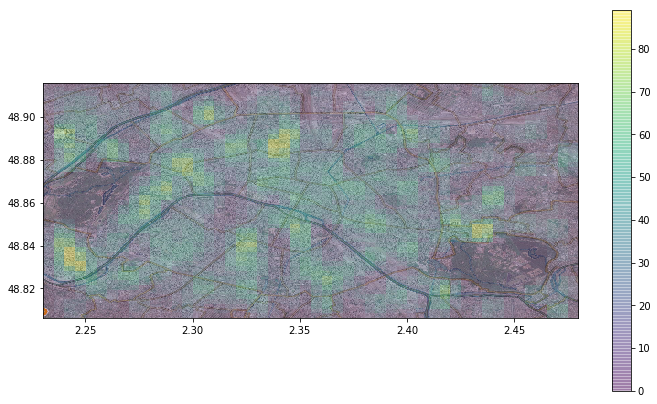

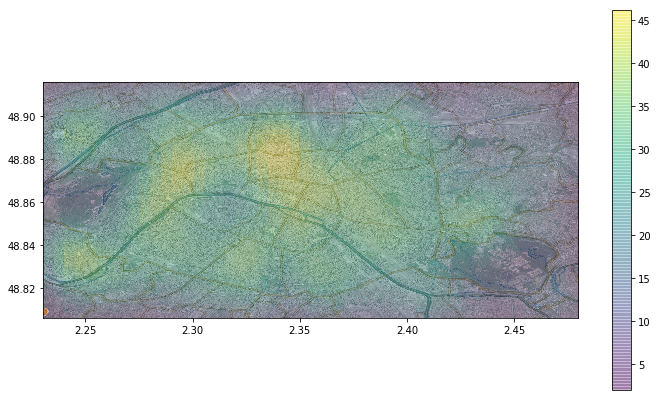

In [52]:
steps = 50
res = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, isOnParzenWindow, hn=0.01))
res2 = affichage(xmin, xmax, ymin, ymax, steps, KernelMethod(geo_mat, gaussianPhi, hn=0.01))

### Classification supervisée
----

In [274]:
poidata.keys()

dict_keys(['furniture_store', 'laundry', 'bakery', 'cafe', 'home_goods_store', 'clothing_store', 'atm', 'lodging', 'night_club', 'convenience_store', 'restaurant', 'bar'])

In [77]:
def getPoiMarks(poidata, typepoi="restaurant"):
    geo_mat = np.zeros((len(poidata[typepoi]),2))
    marks = np.zeros(len(poidata[typepoi])) # note obtenue (va nous servir de label)
    for i,(k,v) in enumerate(poidata[typepoi].items()):
        geo_mat[i,:]=v[0][::-1]
        marks[i] = v[1]
    return geo_mat, marks

On pourrait discrétiser les notes en 5 classes différentes mais la répartition des données en fonction de la note est fortement déséquilibrée.

In [78]:
geo_mat, marks = getPoiMarks(poidata)
for i in range(5):
    print("note ~",i,":", len(marks[(marks - 0.001).astype(int) == i]))

note ~ 0 : 33
note ~ 1 : 55
note ~ 2 : 428
note ~ 3 : 2640
note ~ 4 : 2970


Considérons la classe -1 pour les notes en dessous de 4 et +1 pour celles supérieures à 4

In [104]:
# /!\ Ne pas exécuter deux fois
marks[marks < 4] = -1
marks[marks >= 4] = 1
print("-1 :", len(marks[marks == -1]), "\n1 :", len(marks[marks == 1]))

-1 : 3344 
1 : 3570


Maintenant que l'on a une répartition à peu près équilibrée, on peut commencer la classification.

#### Classifieur

In [110]:
class Classifier:

    def fit(self, X, Y):
        """ X : base d'exemples d'apprentissage
            Y : labels
        """
        raise("Not implemented")
    
    def predict(self, x):
        """ x : un exemple """
        raise("Not implemented")
    
    def accuracy(self, X, Y):
        """ X : exemples, Y : labels """
        pX = np.array([self.predict(x) for x in X])
        return np.mean(pX==Y)


#### Nadaraya-Watson

In [117]:
class NWClassifier(Classifier):
    def __init__(self, kernelFunc, hn=0.01):
        self.window = kernelFunc
        self.hn = hn
    
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        
    def predict(self, x):
        res = np.zeros(len(self.X))
        for j in range(len(self.Y)):
            tmp = np.sum(self.window((x - x_i)/self.hn) for x_i in self.X)
            res[j] = self.Y[j] * self.window((x - self.X[j])/self.hn)
        tmp2 = np.sum(res)
        return 0 if tmp2 == 0 else np.sign(tmp2)
    

In [131]:
nw = NWClassifier(isOnParzenWindow)
nw.fit(geo_mat, marks)
test_ind = np.random.randint(len(geo_mat), size=100)
knn.accuracy(geo_mat[test_ind], marks[test_ind])

0.79000000000000004

#### K-plus proches voisins

In [115]:
def dist_euclidienne(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

def dist_manhattan(x1, x2):
    return np.abs(x1[0] - x2[0]) + np.abs(x1[1] - x2[1])

class KNNClassifier(Classifier):
    def __init__(self, K, distfunc=dist_euclidienne):
        self.K = K
        self.dist = distfunc
        
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        
    def predict(self, x):
        distances = np.zeros(len(self.X))
        for i in range(len(self.X)):
            distances[i] = self.dist(x, self.X[i])
        k_inds = np.argsort(distances)[:self.K]
        classe = np.sum(self.Y[k_inds])
        return 1 if classe == 0 else np.sign(classe)
        

In [116]:
knn = KNNClassifier(3)
knn.fit(geo_mat, marks)
test_ind = np.random.randint(len(geo_mat), size=200)
knn.accuracy(geo_mat[test_ind], marks[test_ind])

0.745